# Importing Libraries

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Displaying signatures

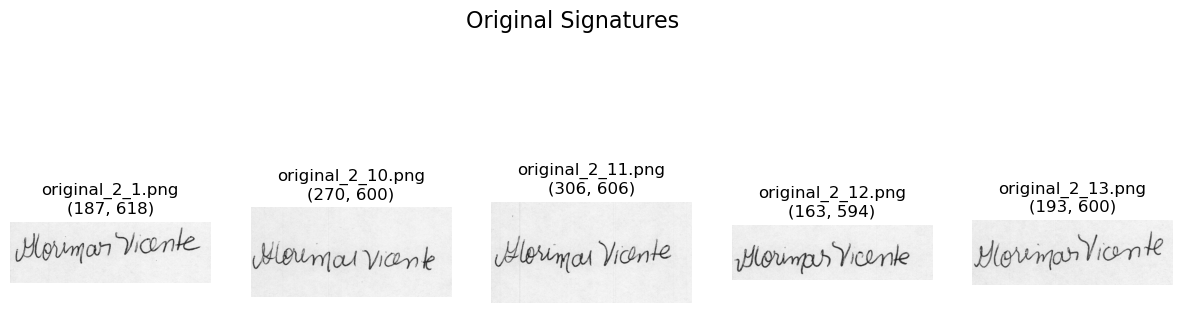

Test Signature Size: (282, 648)


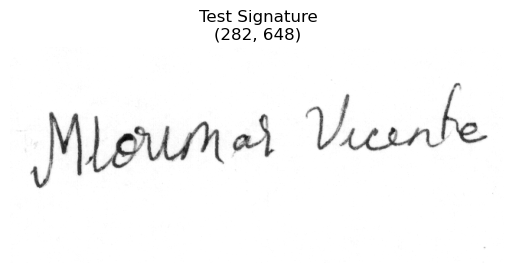

In [2]:
# Path to your dataset
original_signatures_path = "C:/data/dsatm/5th sem/Mini Project/dataset/cedar dataset/trial/original"  # Update this to your folder path
test_signature_path = "C:/data/dsatm/5th sem/Mini Project/dataset/cedar dataset/trial/fake/forgeries_2_1.png"  # Update this to your test image file path

# Helper function to load images and display their sizes
def load_images_from_folder(folder_path):
    images = []
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            images.append((img, filename, img.shape))  # Store image, filename, and size
    return images

# Load original and test signatures
original_signatures = load_images_from_folder(original_signatures_path)
test_signature = cv2.imread(test_signature_path, cv2.IMREAD_GRAYSCALE)

# Display some original signatures and their sizes
def display_images_with_sizes(images, title="Original Signatures", rows=1, cols=5):
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5))
    for i in range(min(len(images), rows * cols)):
        img, filename, size = images[i]
        axes[i].imshow(img, cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(f"{filename}\n{size}")
    fig.suptitle(title, fontsize=16)
    plt.show()

# Show samples and their sizes
display_images_with_sizes(original_signatures, title="Original Signatures")
print(f"Test Signature Size: {test_signature.shape if test_signature is not None else 'Not Loaded'}")
plt.imshow(test_signature, cmap='gray')
plt.title(f"Test Signature\n{test_signature.shape if test_signature is not None else 'N/A'}")
plt.axis("off")
plt.show()


# Pre-processing 

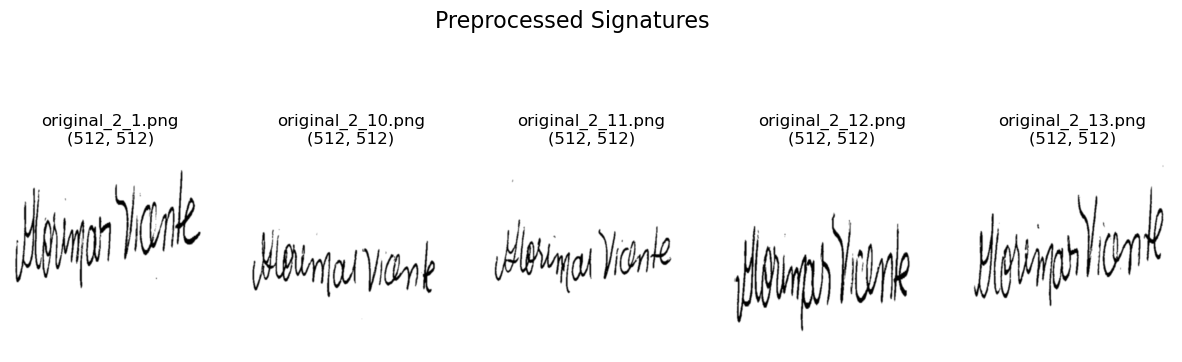

Preprocessed Test Signature Size: (512, 512)


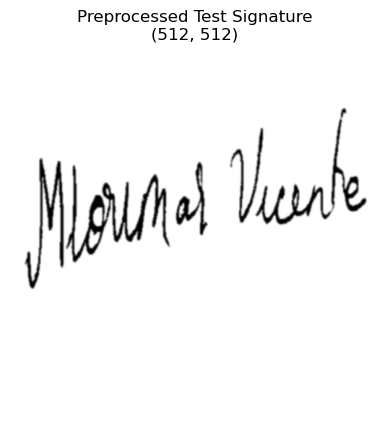

In [3]:
def preprocess_signature(image, resize_dim=(512,512)):
    
    # Convert to grayscale (if not already)
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Resize the image
    image = cv2.resize(image, resize_dim, interpolation=cv2.INTER_AREA)
    
    # Binarize the image using Otsu's thresholding
    _, binary_image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Apply noise reduction (Gaussian blur)
    denoised_image = cv2.GaussianBlur(binary_image, (5, 5), 0)
    
    # Extract the signature region using contours
    contours, _ = cv2.findContours(denoised_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        # Get bounding box of the largest contour
        x, y, w, h = cv2.boundingRect(max(contours, key=cv2.contourArea))
        cropped_image = denoised_image[y:y+h, x:x+w]
        
        # Resize cropped region back to target dimensions
        cropped_image = cv2.resize(cropped_image, resize_dim, interpolation=cv2.INTER_AREA)
    else:
        # If no contours found, use the whole image
        cropped_image = denoised_image
    
    return cropped_image

# Preprocess dataset
def preprocess_dataset(images):
    preprocessed_images = []
    for img, filename, original_size in images:
        preprocessed_img = preprocess_signature(img)
        resize = preprocessed_img.shape
        preprocessed_images.append((preprocessed_img, filename, resize))
    return preprocessed_images

preprocessed_original_signatures = preprocess_dataset(original_signatures)
preprocessed_test_signature = preprocess_signature(test_signature) 

# Display some preprocessed signatures and their sizes
def display_images_with_sizes(images, title="Preprocessed Signatures", rows=1, cols=5):
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5))
    for i in range(min(len(images), rows * cols)):
        img, filename, size = images[i]
        axes[i].imshow(img, cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(f"{filename}\n{size}")
    fig.suptitle(title, fontsize=16)
    plt.show()

# Show samples and their sizes
display_images_with_sizes(preprocessed_original_signatures, title="Preprocessed Signatures")
print(f"Preprocessed Test Signature Size: {preprocessed_test_signature.shape if preprocessed_test_signature is not None else 'Not Loaded'}")
plt.imshow(preprocessed_test_signature, cmap='gray')
plt.title(f"Preprocessed Test Signature\n{preprocessed_test_signature.shape if preprocessed_test_signature is not None else 'N/A'}")
plt.axis("off")
plt.show()


# Comparison using MSE, SSIM and Template Matching scores

## on 16x16

### original comparison

In [ ]:
# Function to calculate MSE between two segments
def calculate_mse(segment1, segment2):
    return np.mean((segment1.astype("float") - segment2.astype("float")) ** 2)

# Function to calculate SSIM between two segments
from skimage.metrics import structural_similarity as compare_ssim

def calculate_ssim(segment1, segment2):
    # Ensure segments meet the win_size requirement
    smallest_dim = min(segment1.shape[0], segment1.shape[1])
    win_size = min(7, smallest_dim) if smallest_dim >= 7 else smallest_dim
    if win_size % 2 == 0:  # Ensure win_size is odd
        win_size -= 1

    score, _ = compare_ssim(segment1, segment2, full=True, win_size=win_size)
    return score

# Template Matching Function
def calculate_template_match(segment1, segment2):
    """
    Calculate the normalized cross-correlation score using template matching.
    Args:
        segment1 (numpy array): Segment from original signature.
        segment2 (numpy array): Segment from test signature.
    Returns:
        float: Template matching score.
    """
    # Ensure the template and image are compatible in size
    if segment1.shape != segment2.shape:
        segment2 = cv2.resize(segment2, (segment1.shape[1], segment1.shape[0]))

    # Apply template matching
    match_result = cv2.matchTemplate(segment1, segment2, cv2.TM_CCOEFF_NORMED)
    return np.max(match_result)

# Enhanced Comparison Function
def compare_signatures_with_template(original_segments_list, test_segments, weights=None):
    """
    Compare test signature segments with original signature segments using 
    MSE, SSIM, and Template Matching.
    
    Args:
        original_segments_list (list): List of segments for each original signature.
        test_segments (list): Segments of the test signature.
        weights (list or None): Weights for individual segments.
    
    Returns:
        list of dicts: Contains scores for MSE, SSIM, and Template Matching.
    """
    results = []
    
    for original_segments in original_segments_list:
        scores = {"mse": [], "ssim": [], "template": []}
        
        for i in range(len(original_segments)):
            # Calculate MSE
            mse_score = calculate_mse(original_segments[i], test_segments[i])
            scores["mse"].append(1 / (1 + mse_score))  # Normalize MSE
            
            # Calculate SSIM
            ssim_score = calculate_ssim(original_segments[i], test_segments[i])
            scores["ssim"].append(ssim_score)
            
            # Calculate Template Matching
            template_score = calculate_template_match(original_segments[i], test_segments[i])
            scores["template"].append(template_score)
        
        # Aggregate scores
        mse_avg = np.average(scores["mse"], weights=weights)
        ssim_avg = np.average(scores["ssim"], weights=weights)
        template_avg = np.average(scores["template"], weights=weights)
        
        # Append final scores for this signature
        results.append({"mse_avg": mse_avg, "ssim_avg": ssim_avg, "template_avg": template_avg})
    
    return results

# Compute similarity scores for all original signatures
comparison_results = compare_signatures_with_template(all_grid_segmented_original[0], all_grid_segmented_original[0][0], weights=None)

# Display Results
for idx, result in enumerate(comparison_results):
    mse_combined_score = np.average(result['mse_avg'])
    ssim_combined_score = np.average(result['ssim_avg'])
    template_combined_score = np.average(result['template_avg'])
    print(
        f"Original Signature {idx + 1}: "
        f"MSE Score = {result['mse_avg']:.4f}, "
        f"SSIM Score = {result['ssim_avg']:.4f}, "
        f"Template Match Score = {result['template_avg']:.4f}"
    )

print("Average MSE :",mse_combined_score,"\nAverage SSIM :",ssim_combined_score,"\nAverage Temp :",template_combined_score)

Original Signature 1: MSE Score = 1.0000, SSIM Score = 1.0000, Template Match Score = 0.9997
Original Signature 2: MSE Score = 0.5308, SSIM Score = 0.7354, Template Match Score = 0.6465
Original Signature 3: MSE Score = 0.5832, SSIM Score = 0.7600, Template Match Score = 0.6488
Original Signature 4: MSE Score = 0.4608, SSIM Score = 0.6737, Template Match Score = 0.6524
Original Signature 5: MSE Score = 0.5345, SSIM Score = 0.7260, Template Match Score = 0.6555
Original Signature 6: MSE Score = 0.4248, SSIM Score = 0.6599, Template Match Score = 0.6618
Original Signature 7: MSE Score = 0.5675, SSIM Score = 0.7434, Template Match Score = 0.6386
Original Signature 8: MSE Score = 0.5163, SSIM Score = 0.6853, Template Match Score = 0.6264
Original Signature 9: MSE Score = 0.5037, SSIM Score = 0.7106, Template Match Score = 0.6432
Original Signature 10: MSE Score = 0.6146, SSIM Score = 0.7582, Template Match Score = 0.6415
Original Signature 11: MSE Score = 0.4794, SSIM Score = 0.6821, Templ

### Fake comparison

In [ ]:
# Function to calculate MSE between two segments
def calculate_mse(segment1, segment2):
    return np.mean((segment1.astype("float") - segment2.astype("float")) ** 2)

# Function to calculate SSIM between two segments
from skimage.metrics import structural_similarity as compare_ssim

def calculate_ssim(segment1, segment2):
    # Ensure segments meet the win_size requirement
    smallest_dim = min(segment1.shape[0], segment1.shape[1])
    win_size = min(7, smallest_dim) if smallest_dim >= 7 else smallest_dim
    if win_size % 2 == 0:  # Ensure win_size is odd
        win_size -= 1

    score, _ = compare_ssim(segment1, segment2, full=True, win_size=win_size)
    return score

# Template Matching Function
def calculate_template_match(segment1, segment2):
    """
    Calculate the normalized cross-correlation score using template matching.
    Args:
        segment1 (numpy array): Segment from original signature.
        segment2 (numpy array): Segment from test signature.
    Returns:
        float: Template matching score.
    """
    # Ensure the template and image are compatible in size
    if segment1.shape != segment2.shape:
        segment2 = cv2.resize(segment2, (segment1.shape[1], segment1.shape[0]))

    # Apply template matching
    match_result = cv2.matchTemplate(segment1, segment2, cv2.TM_CCOEFF_NORMED)
    return np.max(match_result)

# Enhanced Comparison Function
def compare_signatures_with_template(original_segments_list, test_segments, weights=None):
    """
    Compare test signature segments with original signature segments using 
    MSE, SSIM, and Template Matching.
    
    Args:
        original_segments_list (list): List of segments for each original signature.
        test_segments (list): Segments of the test signature.
        weights (list or None): Weights for individual segments.
    
    Returns:
        list of dicts: Contains scores for MSE, SSIM, and Template Matching.
    """
    results = []
    
    for original_segments in original_segments_list:
        scores = {"mse": [], "ssim": [], "template": []}
        
        for i in range(len(original_segments)):
            # Calculate MSE
            mse_score = calculate_mse(original_segments[i], test_segments[i])
            scores["mse"].append(1 / (1 + mse_score))  # Normalize MSE
            
            # Calculate SSIM
            ssim_score = calculate_ssim(original_segments[i], test_segments[i])
            scores["ssim"].append(ssim_score)
            
            # Calculate Template Matching
            template_score = calculate_template_match(original_segments[i], test_segments[i])
            scores["template"].append(template_score)
        
        # Aggregate scores
        mse_avg = np.average(scores["mse"], weights=weights)
        ssim_avg = np.average(scores["ssim"], weights=weights)
        template_avg = np.average(scores["template"], weights=weights)
        
        # Append final scores for this signature
        results.append({"mse_avg": mse_avg, "ssim_avg": ssim_avg, "template_avg": template_avg})
    
    return results

# Compute similarity scores for all original signatures
comparison_results = compare_signatures_with_template(all_grid_segmented_original[0], all_grid_segmented_test[0], weights=None)

# Display Results
for idx, result in enumerate(comparison_results):
    mse_combined_score = np.average(result['mse_avg'])
    ssim_combined_score = np.average(result['ssim_avg'])
    template_combined_score = np.average(result['template_avg'])

    print(
        f"Original Signature {idx + 1}: "
        f"MSE Score = {result['mse_avg']:.4f}, "
        f"SSIM Score = {result['ssim_avg']:.4f}, "
        f"Template Match Score = {result['template_avg']:.4f}"
    )

print("Average MSE :",mse_combined_score,"\nAverage SSIM :",ssim_combined_score,"\nAverage Temp :",template_combined_score)

Original Signature 1: MSE Score = 0.6279, SSIM Score = 0.7838, Template Match Score = 0.7336
Original Signature 2: MSE Score = 0.5826, SSIM Score = 0.7868, Template Match Score = 0.7260
Original Signature 3: MSE Score = 0.6373, SSIM Score = 0.8050, Template Match Score = 0.7227
Original Signature 4: MSE Score = 0.5095, SSIM Score = 0.7212, Template Match Score = 0.7255
Original Signature 5: MSE Score = 0.5885, SSIM Score = 0.7631, Template Match Score = 0.7389
Original Signature 6: MSE Score = 0.4845, SSIM Score = 0.7039, Template Match Score = 0.7488
Original Signature 7: MSE Score = 0.6311, SSIM Score = 0.7963, Template Match Score = 0.7385
Original Signature 8: MSE Score = 0.5447, SSIM Score = 0.7269, Template Match Score = 0.7350
Original Signature 9: MSE Score = 0.5537, SSIM Score = 0.7576, Template Match Score = 0.7441
Original Signature 10: MSE Score = 0.6404, SSIM Score = 0.7957, Template Match Score = 0.7335
Original Signature 11: MSE Score = 0.5372, SSIM Score = 0.7362, Templ